In [73]:
import torch
import torch.nn as nn
import numpy as np
import os 
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import OneHotEncoder

In [3]:
dir = os.getcwd()
os.chdir(dir+"/data")

In [114]:
def load_australian():
    aussie = pd.read_table("australian.dat", header=None, sep=",", skiprows=19)
    X = torch.tensor(aussie.drop(14, axis=1).values, dtype=torch.float)  #.values is necessary to form the tensor
    y = torch.tensor(aussie[14])
    print(X.shape, y.shape)
    print(X.dtype, y.dtype)
    return X, y

def load_iris():
    iris = pd.read_table("iris.data", header=None, sep=",")
    X = torch.tensor(iris.iloc[:, 0:4].values, dtype=torch.float)
    y = iris.iloc[:,4:]
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(y)
    y = ohe.transform(y)
    y = torch.tensor(y)
    return X, y


In [115]:
X,y = load_iris()

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=42)

The Data Loader is for batching and shuffling. Tensor Dataset allows us to join together X_train and y_train

In [176]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=5, shuffle=True) #
test_loader = DataLoader(test_data, batch_size=5, shuffle=True)

In [118]:
print("\nTraining data batches: ")
for X, y in train_loader:
    print(X.shape, y.shape)

print("\nTest data batches: ")
for X, y in test_loader:
    print(X.shape, y.shape)



Training data batches: 
torch.Size([50, 4]) torch.Size([50, 3])
torch.Size([50, 4]) torch.Size([50, 3])
torch.Size([5, 4]) torch.Size([5, 3])

Test data batches: 
torch.Size([45, 4]) torch.Size([45, 3])


In [192]:
class Mehrkanoon(nn.Module):
    def __init__(self, input_size, hidden1_size, num_classes):
        super(Mehrkanoon, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        print(self.fc1.weight.dtype)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, num_classes)
        #self.softmax = nn.Softmax(dim=1)
        

    def forward(self,x):
        out = self.fc1(x)
        #print(out.shape)
        out = self.relu1(out)
        #print(out.shape)
        out = self.fc2(out)
        #print("Before softmax", out)
        #out = self.softmax(out)
        #print("After softmax", out)

        return out


class MehrkanoonLoss(nn.Module):
    def __init__(self):
        super(MehrkanoonLoss, self).__init__()

    def forward(self, model, outputs, targets, gamma):
        loss = nn.CrossEntropyLoss()

        reg = 0
        # we loop through the weight matrices
        for name, W in model.named_parameters():
            if "weight" in name:
                m = W.detach().numpy()
                
                mm = np.matmul(m, np.transpose(m))
                reg += np.trace(mm)
        
            loss_val = loss(outputs, targets)
        
        return reg*gamma/2 + loss_val



In [188]:
model = Mehrkanoon(4,8,3)
print(model)

torch.float32
Mehrkanoon(
  (fc1): Linear(in_features=4, out_features=10, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=10, out_features=3, bias=True)
)


In [112]:
for name, W in model.named_parameters():
    if "weight" in name:
        print(name, W.detach().numpy().shape)

fc1.weight (100, 4)
fc2.weight (3, 100)


We define the cost function according to Mehrkanoon

In [37]:
def cost(model, gamma, preds, y):
    reg = 0
    loss = nn.CrossEntropyLoss()

    # we loop through the weight matrices
    for name, W in model.named_parameters():
        m = W.detach().numpy()
        mm = np.matmul(m, np.transpose(m))
        reg += np.trace(mm)

    loss_val = loss(preds, y)
        
    return reg*gamma/2 + loss_val

In [17]:
# this is to convert a tensor to a numpy object
m1 = model.fc1.weight.detach().numpy()
m2 = model.fc2.weight.detach().numpy()

In [199]:
num_epochs = 200
train_accuracies, test_accuracies = [], []
train_loss, test_loss = [], []


loss_function = MehrkanoonLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr= 0.001)
gamma = 1e-3

for epoch in range(num_epochs):
    epoch_loss = []
    epoch_acc = []

    for X, y in train_loader:
        preds = model(X) #forward pass
        pred_labels = torch.softmax(preds, dim=1)
        loss = loss_function(model, pred_labels, y, gamma)
        optimizer.zero_grad() # set gradients to zero
        loss.backward() # compute gradients
        optimizer.step() #parameter update

        acc = (torch.argmax(pred_labels,1)==torch.argmax(y,1)).float().mean().item()
        epoch_acc.append(acc)
        epoch_loss.append(float(loss))
        # train_accuracies.append(100*torch.mean((torch.argmax(pred_labels,1)==torch.argmax(y,1)).float()).item())

    #print('Epoch %d, Loss %f' % (epoch, float(loss)))

    train_loss.append(np.mean(epoch_loss))
    train_accuracies.append(np.mean(epoch_acc))

    X,y =next(iter(test_loader))
    pred_labels = torch.softmax(model(X), axis=1)
    loss = loss_function(model, pred_labels, y, gamma)
    test_accuracies.append(
        100* torch.mean((torch.argmax(pred_labels,1)==torch.argmax(y,1)).float()).item()
    )
    test_loss.append(float(loss))

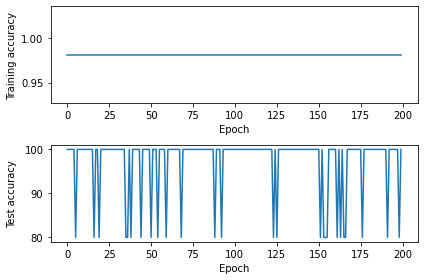

In [201]:
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(nrows=2, ncols=1)

ax = fig.add_subplot(gs[0, 0])
ax.plot(train_accuracies)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training accuracy")

ax = fig.add_subplot(gs[1, 0])
ax.plot(test_accuracies)
ax.set_xlabel("Epoch")
ax.set_ylabel("Test accuracy")

fig.align_labels()
plt.show()

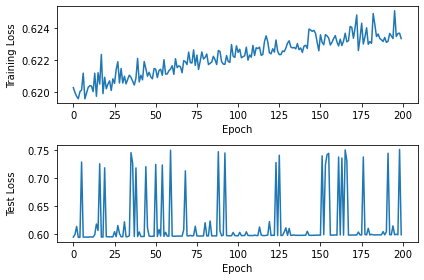

In [202]:
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(nrows=2, ncols=1)

ax = fig.add_subplot(gs[0, 0])
ax.plot(train_loss)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Loss")

ax = fig.add_subplot(gs[1, 0])
ax.plot(test_loss)
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Loss")

fig.align_labels()
plt.show()

In [183]:
pred_labels

tensor([[9.9757e-01, 2.4335e-03, 2.3304e-09],
        [9.7805e-01, 2.1949e-02, 3.0223e-07],
        [9.3659e-05, 2.2823e-01, 7.7168e-01],
        [9.8938e-01, 1.0624e-02, 1.2454e-07],
        [4.6272e-03, 8.3895e-01, 1.5643e-01]], grad_fn=<SoftmaxBackward0>)